# Bike Sharing Demand

# 0. 세팅

## 0.1 데이터 불러오기

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seongyeoncau","key":"d483d94443e42405b24403cc7b2491e8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c bike-sharing-demand

!unzip bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 67.4MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


## 0.2 모듈 불러오기

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import missingno as msno

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_palette("pastel")

# 1. 데이터 확인

In [ ]:
train = pd.read_csv('train.csv') # 훈련 데이터
test = pd.read_csv('test.csv') # 테스트 데이터

# 훈련 데이터와 테스트 데이터 크기 확인
train.shape, test.shape

((10886, 12), (6493, 9))

- 훈련 데이터는 10.886행 12개의 칼럼으로 구성되어 있는 반면, 테스트 데이터는 6,493행 9개의 칼럼으로 구성되어 있다

## 1.1 전반적인 데이터 파악



> - 케글 데이터 설명에 따르면 2년간의 시간별 대여량 데이터가 제공되고, 훈련 세트는 매월 19일까지, 테스트 세트는 20일부터 말일까지로 구성된다.
> - 대여 기간 이전에 사용 가능한 정보만 사용하여 테스트 세트에 포함된 각 시간 동안 임대된 자전거의 총 수를 예측해야 한다.

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


- 데이터를 살펴보니 범주형 데이터와 연속형 데이터가 존재함을 볼 수 있었다.

<Axes: >

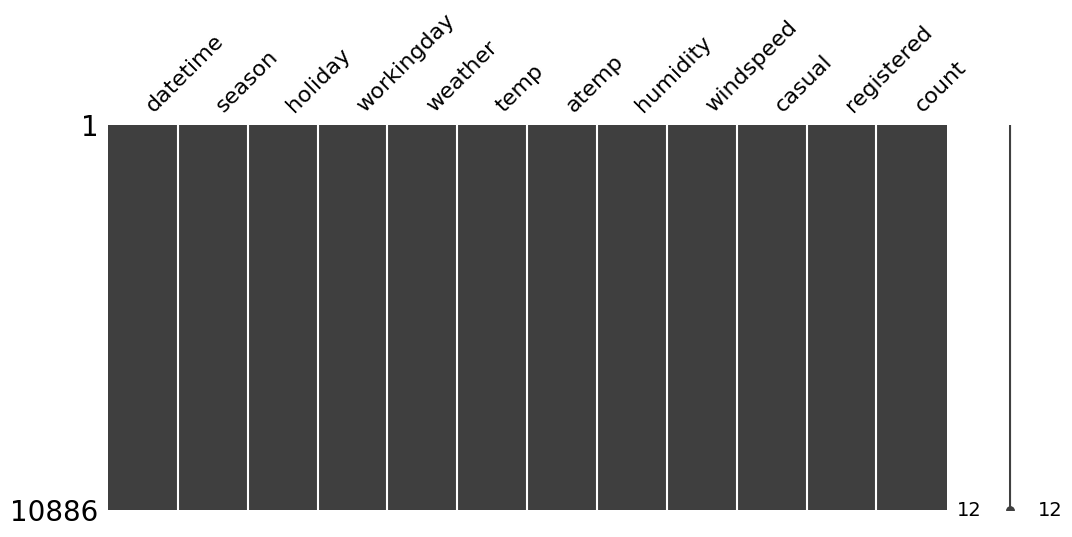

In [ ]:
a

<Axes: >

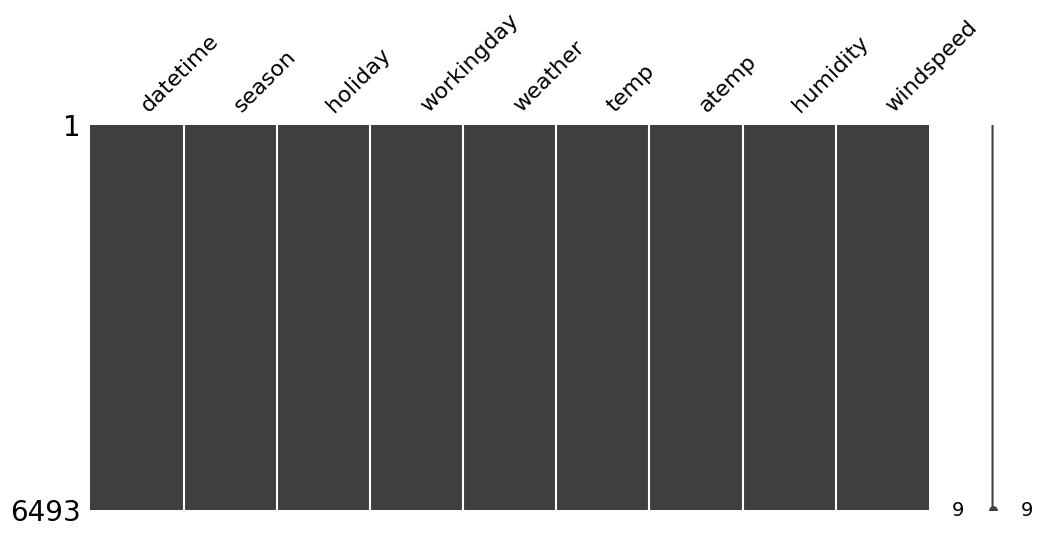

In [ ]:
msno.matrix(test,figsize=(12,5))

- 결측치를 파악해보니 train과 test 데이터 모두 결측치는 없다
- 비어있는 결측치는 없으나 다른 값으로 채워져 있나 확인해봐야 한다

## 1.2 데이터 필드 구성
- datetime : 기록 일시(1시간 간격)
- season : 계절(1봄, 2여름, 3가을, 4겨울)
- holiday : 공휴일 여부(0공휴일 아님, 1공휴일)
- workingday : 근무일 여부(0근무일 아님, 1근무일_주말과 공휴일이 아니면 근무일로 간주)
- weather : 날씨(1맑음, 2옅은 안개 및 약간 흐림, 3약간의 눈이나 비 천둥번개와 흐림, 4폭우와 천둥번개 및 눈 짙은 안개)
- temp : 실제 온도
- atemp : 체감 온도
- humidity : 상대 습도
- windspeed : 풍속
--------------------------
### train 데이터에만 존재하는 feature
- casual : 등록되지 않은 사용자(비회원) 대여 수량
- registered : 등록된 사용자(회원) 대여 수량

### 예측해야 할 타깃값
- count : 자전거 대여 수량 (회원 + 비회원)

## 1.3 <b>``데이터 분석 방향성``</b>
1. 시계열 데이터 (datetime) : 시계열 데이터 분석을 통해 시간적 특성에 따른 대여량의 변화 및 차이를 확인한다.
  - datetime 으로 타입을 변환한 뒤 파생변수를 생성한다 (day, month, dayofweek 등)
2. 날씨 관련 연속형 데이터 (temp, atemp, humidity, windspeed)
  - 이상치 파악
3. 범주형 데이터 (season, holiday, workingday, weather) : 명목형과 순서형을 구분한다
  - 명목형 : holiday, workingday
  - 순서형 : season, weather
4. target : train 데이터에만 있는 casual과 registered feature에 대해서 어떻게 다뤄야 할 지 고민해본다.
  - 예측해야 하는 타겟값이 두 피처의 합으로 보여진다.
  - 각각을 예측한 뒤에 합해서 결과를 낼지 혹은 한번에 예측해야 할 지 두 가지 예측 방향성을 생각해 볼 수 있다.


# 2. 데이터 탐색

## 2.1 시계열 데이터 (datetime)
  - 시계열 데이터 분석을 통해 시간적 특성에 따른 대여량의 변화 및 차이를 확인한다.
  - datetime 으로 타입을 변환한 뒤 파생변수를 생성한다 (day, month, dayofweek 등)

- 훈련 세트는 매월 19일까지, 테스트 세트는 20일부터 말일까지로 구성된다 하였으므로 day는 파생변수로 사용하지 않는다.
- 만들어진 파생변수는 일종의 범주형 데이터로 보고 범주형 데이터와 함께 시각화 및 분석을 진행할 예정이다.

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train['day_name'] = train['datetime'].dt.day_name()

## 2.2 날씨 관련 수치형(연속형) 데이터 (temp, atemp, humidity, windspeed)
  - 이상치 파악

In [ ]:
numerical = ['temp','atemp', 'humidity', 'windspeed']
train[numerical].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


- humidity와 windspeed의 데이터에서 최솟값으로 0이 있는데, 이것이 실제로 가능한 수치인지 생각해 볼 필요가 있다.
- 체감온도와 실제온도는 관련성이 높은 feature로 보이기에 두 데이터 간의 차이가 너무 크다면 이 또한 이상치로 보아야할 것이다.

### 2.2.1 분포 파악

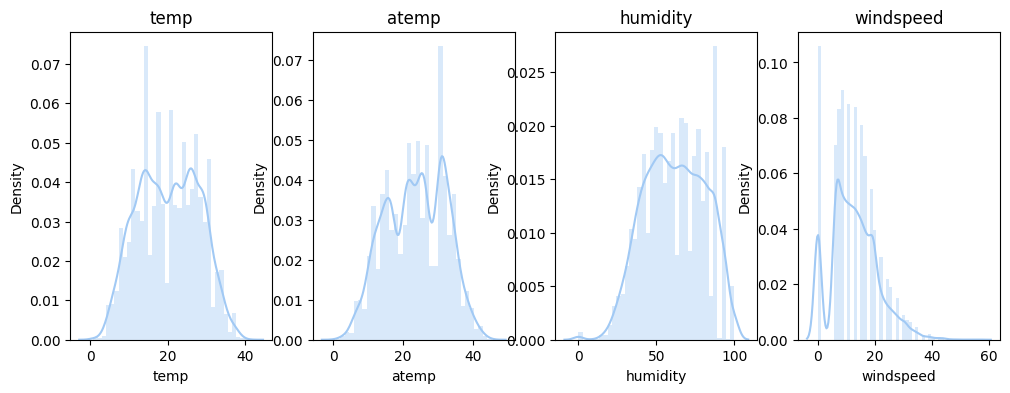

In [ ]:
# 4개의 feature에 대한 distplot 그리기
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical):
    plt.subplot(1, 4, i + 1)
    sns.distplot(train[feature], kde=True)
    plt.title(feature)

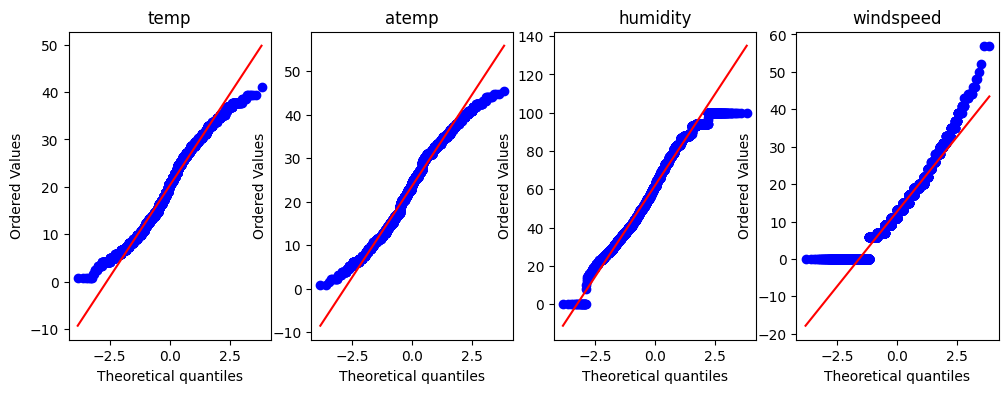

In [ ]:
# 4개의 feature에 대한 qqplot 그리기
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical):
    plt.subplot(1, 4, i + 1)
    stats.probplot(train[feature], dist="norm", plot=plt)
    plt.title(feature)

- 풍속(windspeed)의 경우 왼쪽으로 치우쳐져 있는 것을 볼 수 있다.
  - 로그 변환을 고려해볼 필요가 있다.
- 풍속(windspeed)은 0이 될 수 없으므로 사실상 이상치라 볼 수 있고 이를 다른 값으로 대체해 주는 것이 바람직 해 보인다.

### 2.2.1 수치형 데이터의 상관관계 파악

#### 온도와 체감온도에 대한 산점도

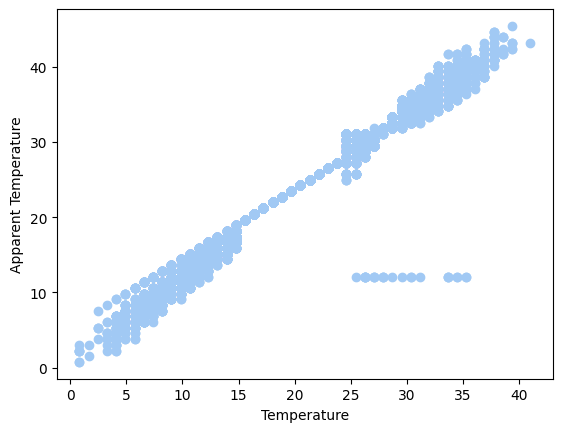

In [ ]:
# 온도와 체감 온도에 대한 산점도 그리기
plt.scatter(train['temp'], train['atemp'])
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

- 온도와 체감온도가 상당히 차이가 많이 나는 데이터 확인 후 이상치 처리를 해볼 것이다.
- 유독 차이가 많이 나는 부분이 체감온도가 하나의 값인 것으로 보아 기록시 나타난 이상치로 보인다

#### 이상치 처리
- 실제온도 / 체감온도의 비율로 이상치를 파악해보았다.
- 이 비율이 2를 넘어가면 이상치로 처리해주었다

In [ ]:
(train['temp'] / train['atemp']).describe()

count    10886.000000
mean         0.849612
std          0.099631
min          0.270627
25%          0.811881
50%          0.852800
75%          0.876179
max          2.909241
dtype: float64

In [ ]:
train.loc[train['temp'] / train['atemp'] > 2,'atemp_out'] = 1
train.atemp_out.fillna(0, inplace=True)

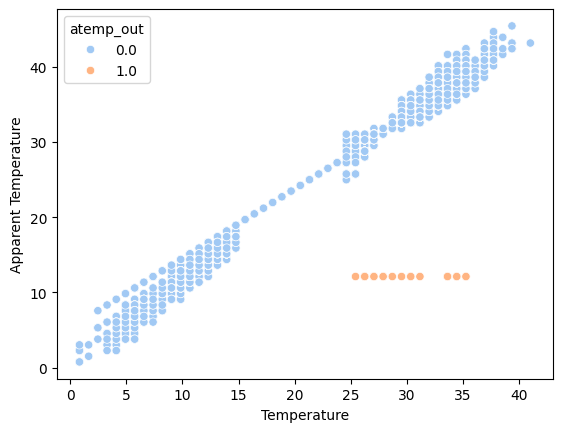

In [ ]:
sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

In [ ]:
train[train.atemp_out == 1]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,day_name,atemp_out
8991,2012-08-17 00:00:00,3,0,1,1,27.88,12.12,57,11.0014,21,67,88,2012,8,0,4,Friday,1.0
8992,2012-08-17 01:00:00,3,0,1,1,27.06,12.12,65,7.0015,16,38,54,2012,8,1,4,Friday,1.0
8993,2012-08-17 02:00:00,3,0,1,1,27.06,12.12,61,8.9981,4,15,19,2012,8,2,4,Friday,1.0
8994,2012-08-17 03:00:00,3,0,1,1,26.24,12.12,65,7.0015,0,6,6,2012,8,3,4,Friday,1.0
8995,2012-08-17 04:00:00,3,0,1,1,26.24,12.12,73,11.0014,0,9,9,2012,8,4,4,Friday,1.0
8996,2012-08-17 05:00:00,3,0,1,1,26.24,12.12,73,7.0015,2,34,36,2012,8,5,4,Friday,1.0
8997,2012-08-17 06:00:00,3,0,1,1,25.42,12.12,78,8.9981,6,151,157,2012,8,6,4,Friday,1.0
8998,2012-08-17 07:00:00,3,0,1,1,26.24,12.12,73,7.0015,11,368,379,2012,8,7,4,Friday,1.0
8999,2012-08-17 08:00:00,3,0,1,1,27.88,12.12,65,8.9981,43,625,668,2012,8,8,4,Friday,1.0
9000,2012-08-17 09:00:00,3,0,1,1,28.70,12.12,58,7.0015,58,320,378,2012,8,9,4,Friday,1.0


> - 데이터를 확인해보니 2012년 08월 17일의 체감온도가 12.12로 일정하게 잘 못 기록된 것으로 보인다.
> -  랜덤 포레스트를 활용하여 이상치를 보간해 주었다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# atemp_out이 1인 데이터의 인덱스를 추출
index_outlier = train[train['atemp_out'] == 1].index

# atemp_out이 0인 데이터를 학습 데이터로 사용
X_train = train[train['atemp_out'] == 0][['temp', 'humidity', 'windspeed','month','hour','dayofweek']]
y_train = train[train['atemp_out'] == 0]['atemp']

# 랜덤 포레스트 모델 생성
model = RandomForestRegressor()

# 모델 학습
model.fit(X_train, y_train)

# atemp_out이 1인 데이터의 온도, 습도, 풍속을 사용하여 체감온도 예측
y_pred = model.predict(train[train['atemp_out'] == 1][['temp', 'humidity', 'windspeed','month','hour','dayofweek']])

# 예측한 체감온도를 train 데이터에 업데이트
train.loc[index_outlier, 'atemp'] = y_pred

랜덤 포레스트 수행 결과

In [ ]:
y_pred

array([31.82   , 31.06   , 31.06   , 30.305  , 30.305  , 30.305  ,
       29.545  , 30.305  , 31.82   , 32.575  , 34.09   , 34.85   ,
       37.13515, 36.99165, 37.91775, 37.0747 , 36.33455, 36.3725 ,
       36.3649 , 34.09   , 33.335  , 31.82   , 30.305  , 28.79   ])

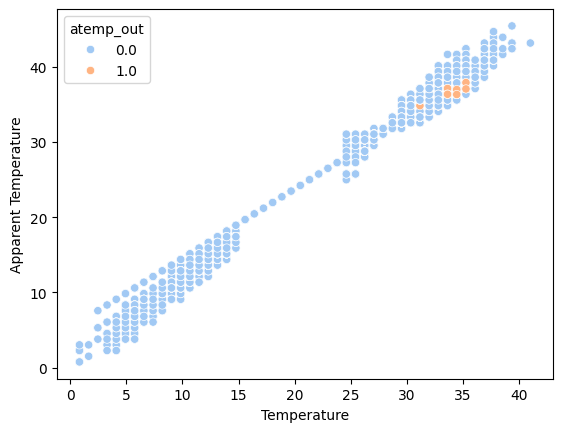

In [ ]:
sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

In [ ]:
# atemp_out 열을 삭제
train.drop('atemp_out', axis=1, inplace=True)

#### 다른 변수 간의 산점도
- 습도와 체감온도, 체감온도와 풍속, 습도와 풍속 등 일반적으로 관계가 있을 것이라 알려진 데이터 들의 관계를 파악해보고자 scatterplot을 확인해보았다
- 크게 관계는 없어보이나 풍속이 0인 경우가 있는데 이는 실제로 가능한 수치가 아니므로 확인해보아야할 것 같다

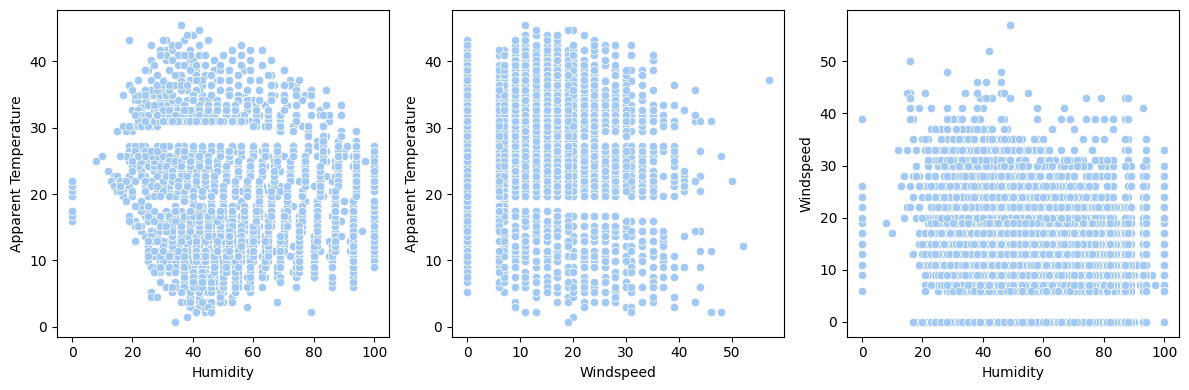

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(data=train, x='humidity', y='atemp')
plt.xlabel('Humidity')
plt.ylabel('Apparent Temperature')

plt.subplot(1, 3, 2)
sns.scatterplot(data=train, x='windspeed', y='atemp')
plt.xlabel('Windspeed')
plt.ylabel('Apparent Temperature')

plt.subplot(1, 3, 3)
sns.scatterplot(data=train, x='humidity', y='windspeed')
plt.xlabel('Humidity')
plt.ylabel('Windspeed')

plt.tight_layout()
plt.show()


풍속 0인 데이터 처리

In [ ]:
# 풍속이 0인 데이터의 인덱스 추출
index_windspeed_0 = train[train['windspeed'] == 0].index

# 풍속이 0이 아닌 데이터를 학습 데이터로 사용
X_train = train[train['windspeed'] != 0][['temp', 'humidity', 'atemp','month','hour','dayofweek']]
y_train = train[train['windspeed'] != 0]['windspeed']

# 랜덤 포레스트 모델 생성
model = RandomForestRegressor()

# 모델 학습
model.fit(X_train, y_train)

# 풍속이 0인 데이터의 온도, 습도, 체감온도를 사용하여 풍속 예측
y_pred = model.predict(train[train['windspeed'] == 0][['temp', 'humidity', 'atemp','month','hour','dayofweek']])

# 예측한 풍속을 train 데이터에 업데이트
train.loc[index_windspeed_0, 'windspeed'] = y_pred


#### 히트맵을 통한 상관관계 파악

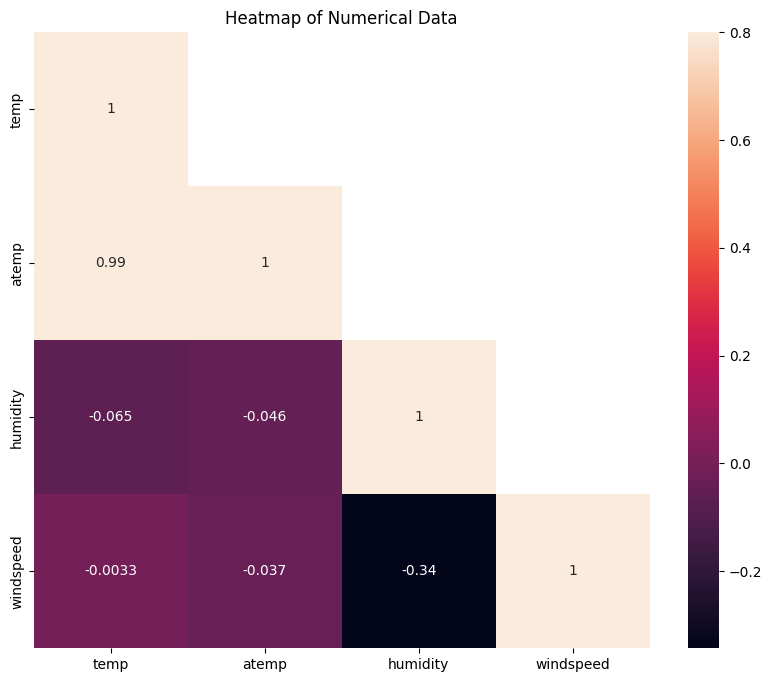

In [ ]:
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed']].corr()
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(10,8)
sns.heatmap(corrMat, mask=mask,vmax=.8, square=True,annot=True)

ax.set(title='Heatmap of Numerical Data');

#### `변수 간 상관관계 파악`
- 체감 온도와 실제 온도는 상식적으로도 상당히 상관관계가 높을 수 밖에 없다.
- 습도와 풍속은 약한 음의 상관관계가 있다.
- 그 외에 다른 변수들간에는 상관관계가 거의 없는 것으로 보여진다.

## 2.3 범주형 데이터 (season, holiday, workingday, weather)

- season 데이터는 범주형 데이터이지만 날씨의 특성상 여름, 봄, 가을, 겨울 순으로 온도가 낮아지기에 이를 순서형으로도 볼 수 있다. 데이터 분석을 통해 단순 명목형으로 볼 것인지 혹은 순서형으로 변환해 볼지 고민해 볼 계정이다.
- weather 데이터는 1은 맑은 날씨고 4로 갈수록 자전거 타기 어려운 날씨로 보여진다.
  - 따라서 순서형 데이터로 생각하고 데이터를 분석할 예정이다.
- 시각화 시 의미가 잘 드러나도록 문자열로 바꾸고 진행한다.

In [ ]:
train['season'] = train['season'].map({1: 'Spring',
                                      2: 'Summer',
                                      3: 'Fall',
                                      4: 'Winter'})
train['weather'] = train['weather'].map({1: 'Clear',
                                        2: 'Mist, Few clouds',
                                        3: 'Light Snow, Rain, Thunderstorm',
                                        4: 'Heavy Rain, Thunderstorm, Snow, Fog'})

### 2.3.1 범주형 데이터 분포 파악
- 범주형 데이터는 countplot을 통해 값들이 고르게 존재하는 지 확인 할 수 있다
- season, year, month 등의 데이터는 고르게 분포되어있는 것을 이미 확인했으므로 그 외의 데이터를 확인해보고자 한다.

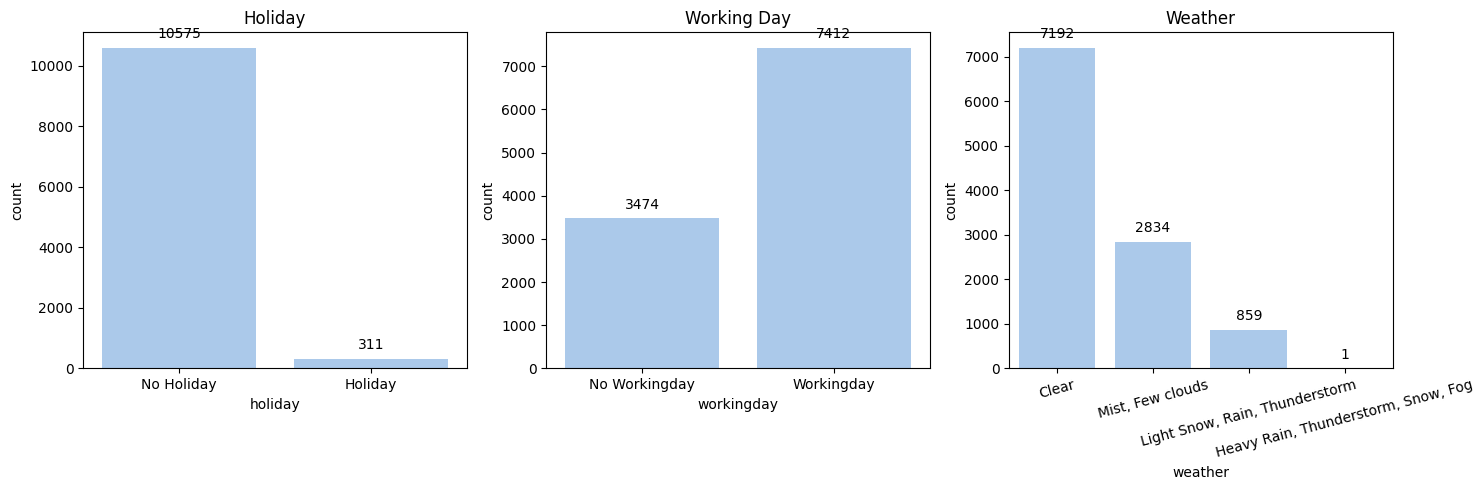

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# holiday
sns.countplot(x='holiday', data=train, ax=axes[0])
axes[0].set_title('Holiday')
axes[0].set_xticklabels(['No Holiday', 'Holiday'])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# workingday
sns.countplot(x='workingday', data=train, ax=axes[1])
axes[1].set_title('Working Day')
axes[1].set_xticklabels(['No Workingday', 'Workingday'])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# weather
sns.countplot(x='weather', data=train, ax=axes[2])
axes[2].set_title('Weather')
axes[2].set_xticklabels(['Clear', 'Mist, Few clouds', 'Light Snow, Rain, Thunderstorm', 'Heavy Rain, Thunderstorm, Snow, Fog'])
axes[2].set_xticklabels(['Clear', 'Mist, Few clouds', 'Light Snow, Rain, Thunderstorm', 'Heavy Rain, Thunderstorm, Snow, Fog'], rotation=15)
for p in axes[2].patches:
    axes[2].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()


# 3. 타겟값(count)과의 분포 파악

- train 데이터에만 있는 casual과 registered feature에 대해서 어떻게 다뤄야 할 지 고민해본다.
  - 예측해야 하는 타겟값이 두 피처의 합으로 보여진다.
  - 각각을 예측한 뒤에 합해서 결과를 낼지 혹은 한번에 예측해야 할 지 두 가지 예측 방향성을 생각해 볼 수 있다.

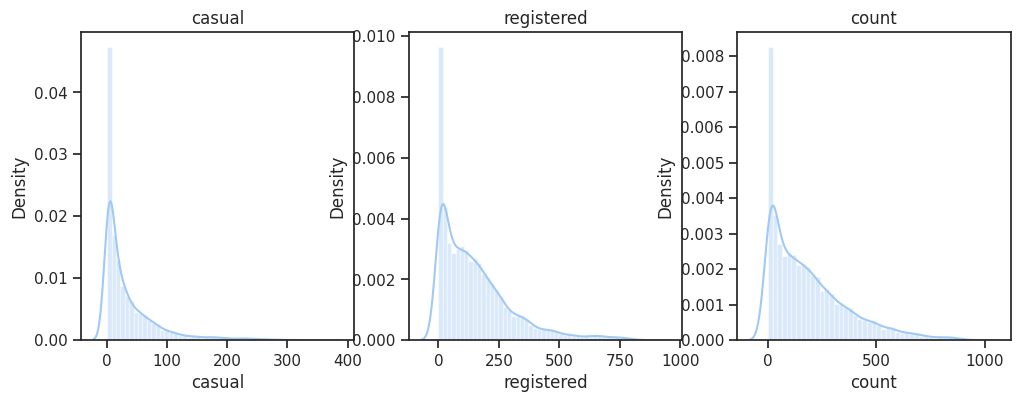

In [ ]:
targets = ['casual',	'registered',	'count']
# 3개의 targets에 대한 distplot 그리기
plt.figure(figsize=(12, 4))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.distplot(train[target], kde=True)
    plt.title(target)

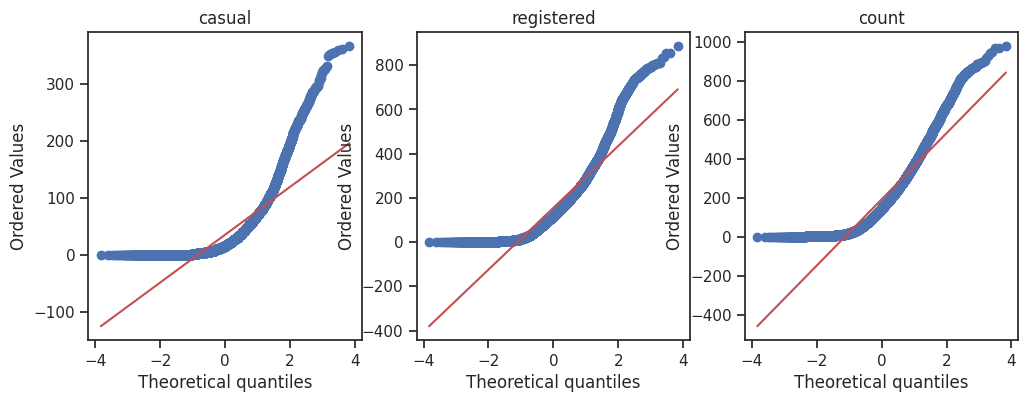

In [ ]:
# 4개의 feature에 대한 qqplot 그리기
plt.figure(figsize=(12, 4))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    stats.probplot(train[target], dist="norm", plot=plt)
    plt.title(target)

- 분포가 왼쪽으로 많이 편향되어있는 것을 볼 수 있다.
- ``회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 함``
- 현재 타깃값인 count는 정규분포를 따르지 않아 현재 타깃값을 그대로 사용해 모델링하면 좋은 성능 기대 어려움
- 이에 따라 데이터 분포를 정규분포에 가깝게 만들기 위해 **로그변환**을 하고자 한다

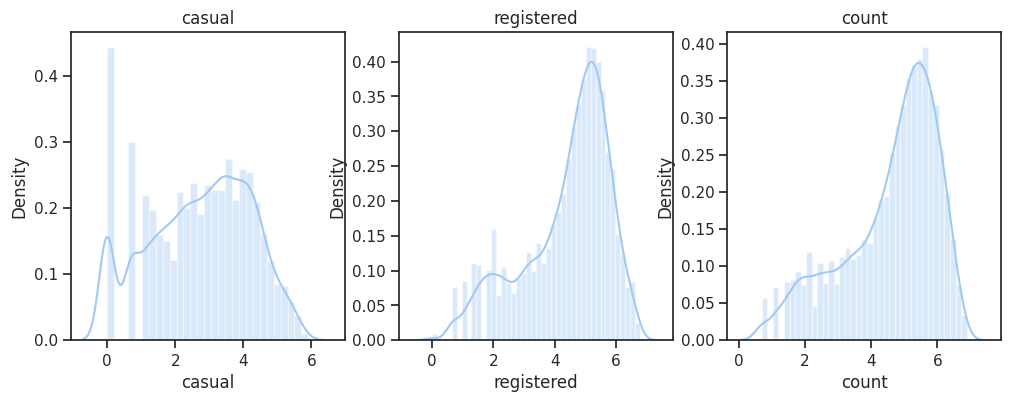

In [ ]:
targets = ['casual',	'registered',	'count']
# 3개의 targets에 대한 distplot 그리기
plt.figure(figsize=(12, 4))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.distplot(np.log1p(train[target]), kde=True)
    plt.title(target)

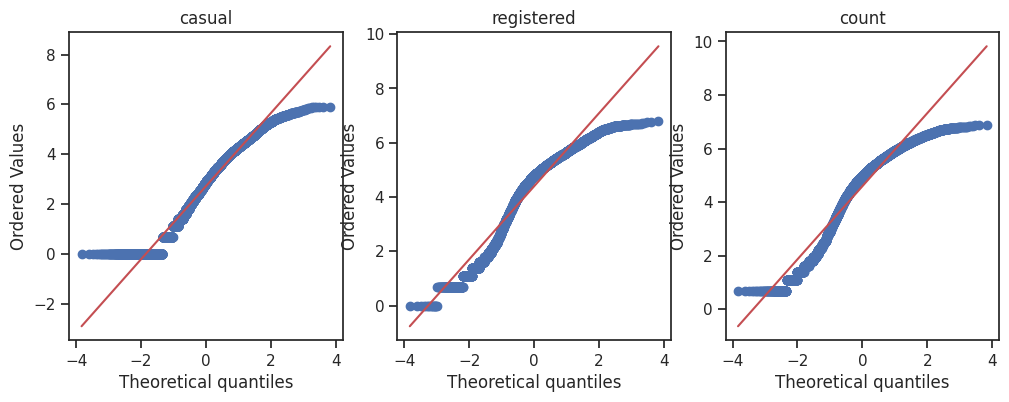

In [ ]:
# 4개의 feature에 대한 qqplot 그리기
plt.figure(figsize=(12, 4))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    stats.probplot(np.log1p(train[target]), dist="norm", plot=plt)
    plt.title(target)

- 변환 전보다 정규분포에 가까워진 것을 볼 수 있다.
- casual과 registered의 숫자차이도 나고 분포의 차이도 나는 것을 볼 수 있다.

## 3.1 타겟값과 범주형 변수 간의 관계

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

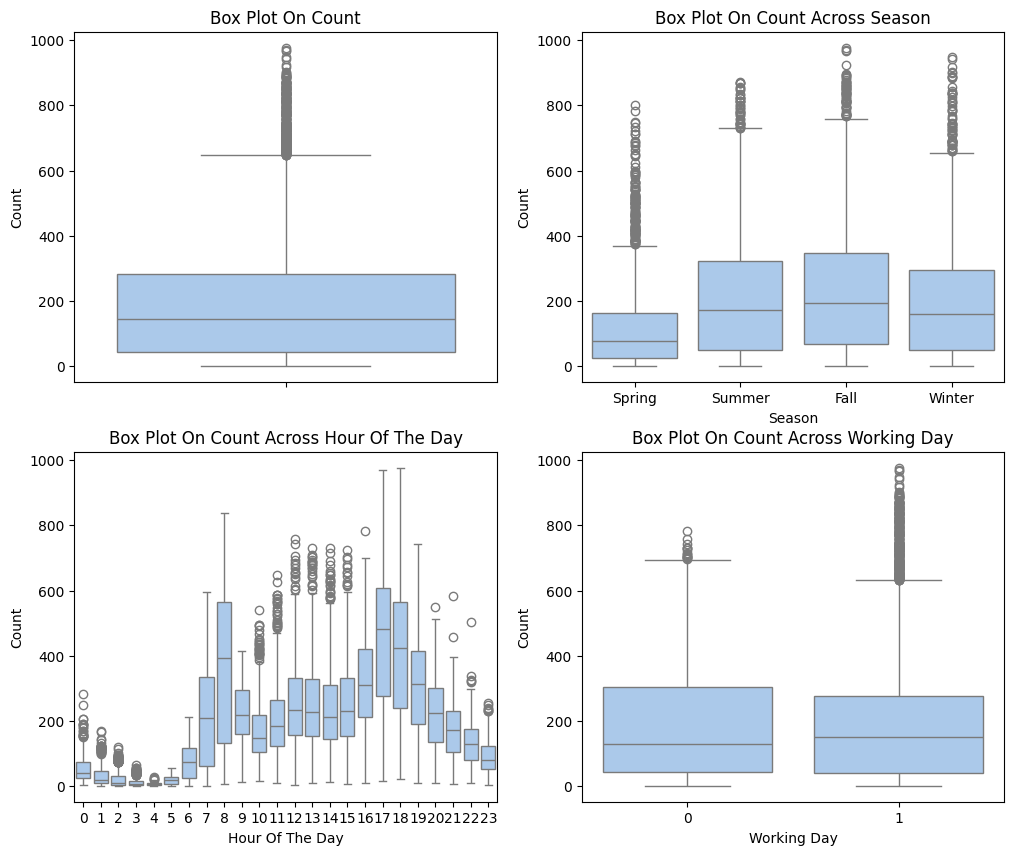

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y="count", orient="v",ax=axes[0][0])
sns.boxplot(data=train, y="count", x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train, y="count", x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train, y="count", x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

- <b>`계절(Season)`</b> : 대여량의 중앙값을 비교해보면, 계절의 따른 대여량 차이에는 봄이 다른 계절에 비해 대여량이 낮은 것으로 보인다.
- <b>`시간대(Hour of the Day)`</b> : 대여량의 중앙값을 비교해보면, 아침 7-9시, 저녁 5-6시 시간대에 대여량이 다른 시간대에 비해 상당히 많음을 볼 수 있다. 이는 출퇴근 시간대에 자전거를 이용하여 대여량이 많은 것으로 유추할 수 있다.
- 이에 대한 증거로, 대부분의 이상치 값(대여량이 높은 데이터)들은 평일에 분포되어 있음을 볼 수 있다.

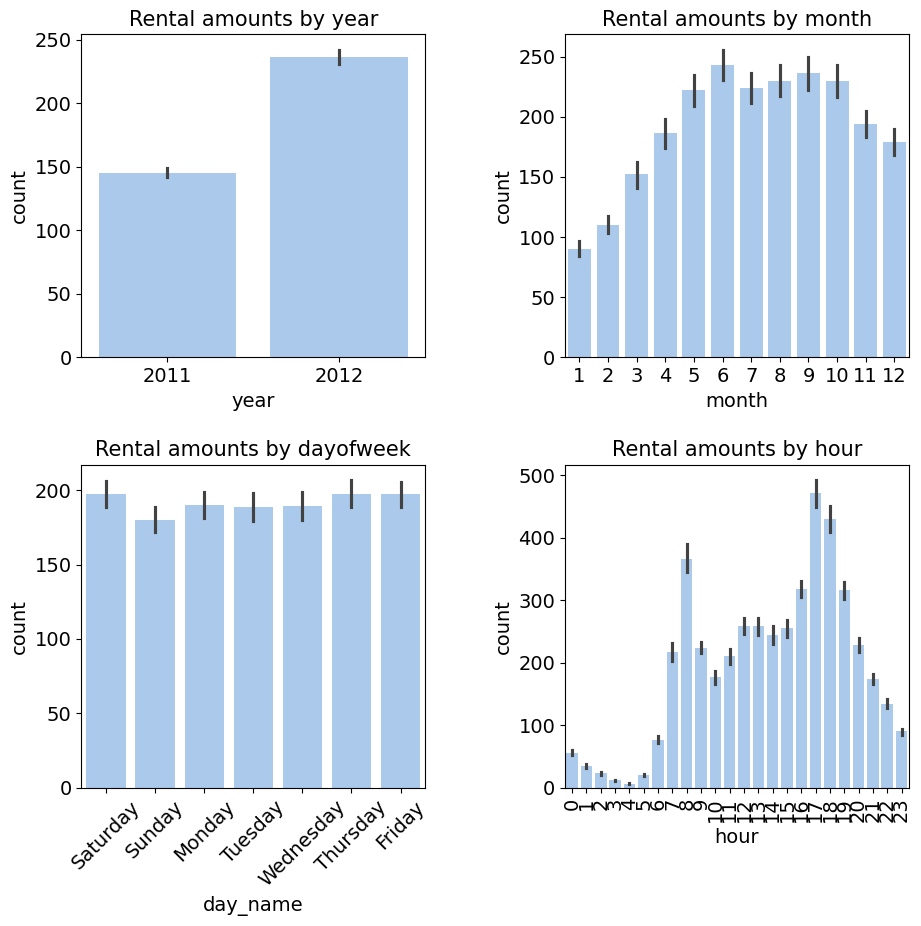

In [ ]:
mpl.rc('font', size=14) # 폰트 크기 설정
mpl.rc('axes', titlesize=15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=2, ncols=2) # 3행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9인치로 설정

sns.barplot(x='year', y='count', data=train, ax=axes[0, 0]) # ax 파라미터에는 AxesSubplot 객체를 전달
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1]) # 0행 0열의 축부터 2행 1열의 축까지 순서대로 전달
sns.barplot(x='day_name', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])

axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by dayofweek')
axes[1, 1].set(title='Rental amounts by hour')

axes[1, 0].tick_params(axis='x', labelrotation=45)
axes[1, 1].tick_params(axis='x', labelrotation=90)

- 연도별 평균 대여량은 2011년보다 2012년에 대여가 많았음
- 월별 평균 대여량을 비교해보면, 6월에 가장 많고 1월에 가장 적다. 날씨가 따뜻할수록 대여 수량이 많다고 짐작할 수 있다.
- 요일별 평균 대여량에는 뚜렷한 차이가 없다.
- 시간별 평균 대여량은 새벽 4시에 대여 수량이 가장 적고, 아침 8시와 저녁 5-6시에 대여가 가장 많다.
  - 이는 사람들이 등하교 또는 출퇴근 길에 자전거를 다수 이용한다 짐작할 수 있다.

<Axes: xlabel='count', ylabel='weather'>

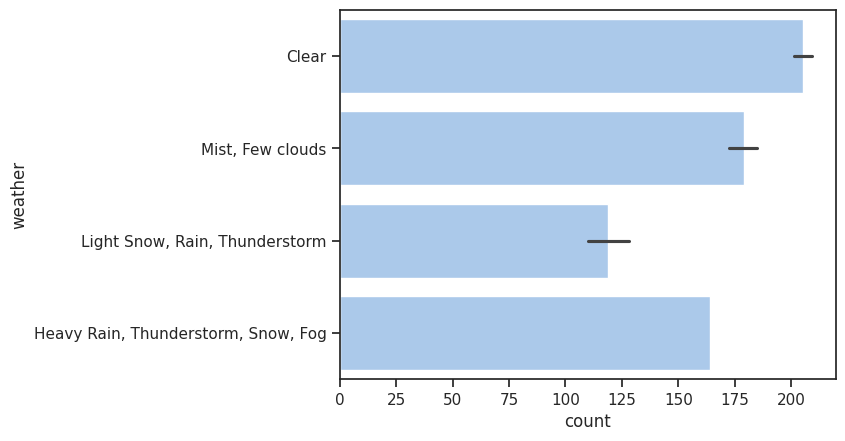

In [ ]:
sns.barplot(y='weather', x='count', data=train)

- 날씨가 안좋은데 대여량이 많은 건 뭔가 이상해 보인다. 확인해보자

In [ ]:
train.weather.unique()

array(['Clear', 'Mist, Few clouds', 'Light Snow, Rain, Thunderstorm',
       'Heavy Rain, Thunderstorm, Snow, Fog'], dtype=object)

In [ ]:
train[train.weather.str.contains('Heavy')]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,day_name
5631,2012-01-09 18:00:00,Spring,0,1,"Heavy Rain, Thunderstorm, Snow, Fog",8.2,11.365,86,6.0032,6,158,164,2012,1,18,0,Monday


In [ ]:
train[(train['datetime'] >= '2012-01-09 16:00:00') & (train['datetime'] <= '2012-01-09 20:59:59')]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,day_name
5629,2012-01-09 16:00:00,Spring,0,1,"Light Snow, Rain, Thunderstorm",9.02,12.880,87,6.0032,3,46,49,2012,1,16,0,Monday
5630,2012-01-09 17:00:00,Spring,0,1,"Light Snow, Rain, Thunderstorm",9.02,13.635,87,0.0000,5,147,152,2012,1,17,0,Monday
5631,2012-01-09 18:00:00,Spring,0,1,"Heavy Rain, Thunderstorm, Snow, Fog",8.20,11.365,86,6.0032,6,158,164,2012,1,18,0,Monday
5632,2012-01-09 19:00:00,Spring,0,1,"Light Snow, Rain, Thunderstorm",8.20,11.365,93,6.0032,3,187,190,2012,1,19,0,Monday
5633,2012-01-09 20:00:00,Spring,0,1,"Mist, Few clouds",8.20,11.365,86,6.0032,5,127,132,2012,1,20,0,Monday


- 이상치라고 생각했으나 비가 와서 얼른 집에 가려고 자전거를 빌렸을 가능성도 있을 것 같다.
- weather(Heavy Rain, Thunderstorm, Snow, Fog)이 4인 데이터는 1개 뿐이므로 주변 값인 3(Light Snow, Rain, Thunderstorm)으로 추후 합쳐 줄 것이다.

<Axes: xlabel='hour', ylabel='count'>

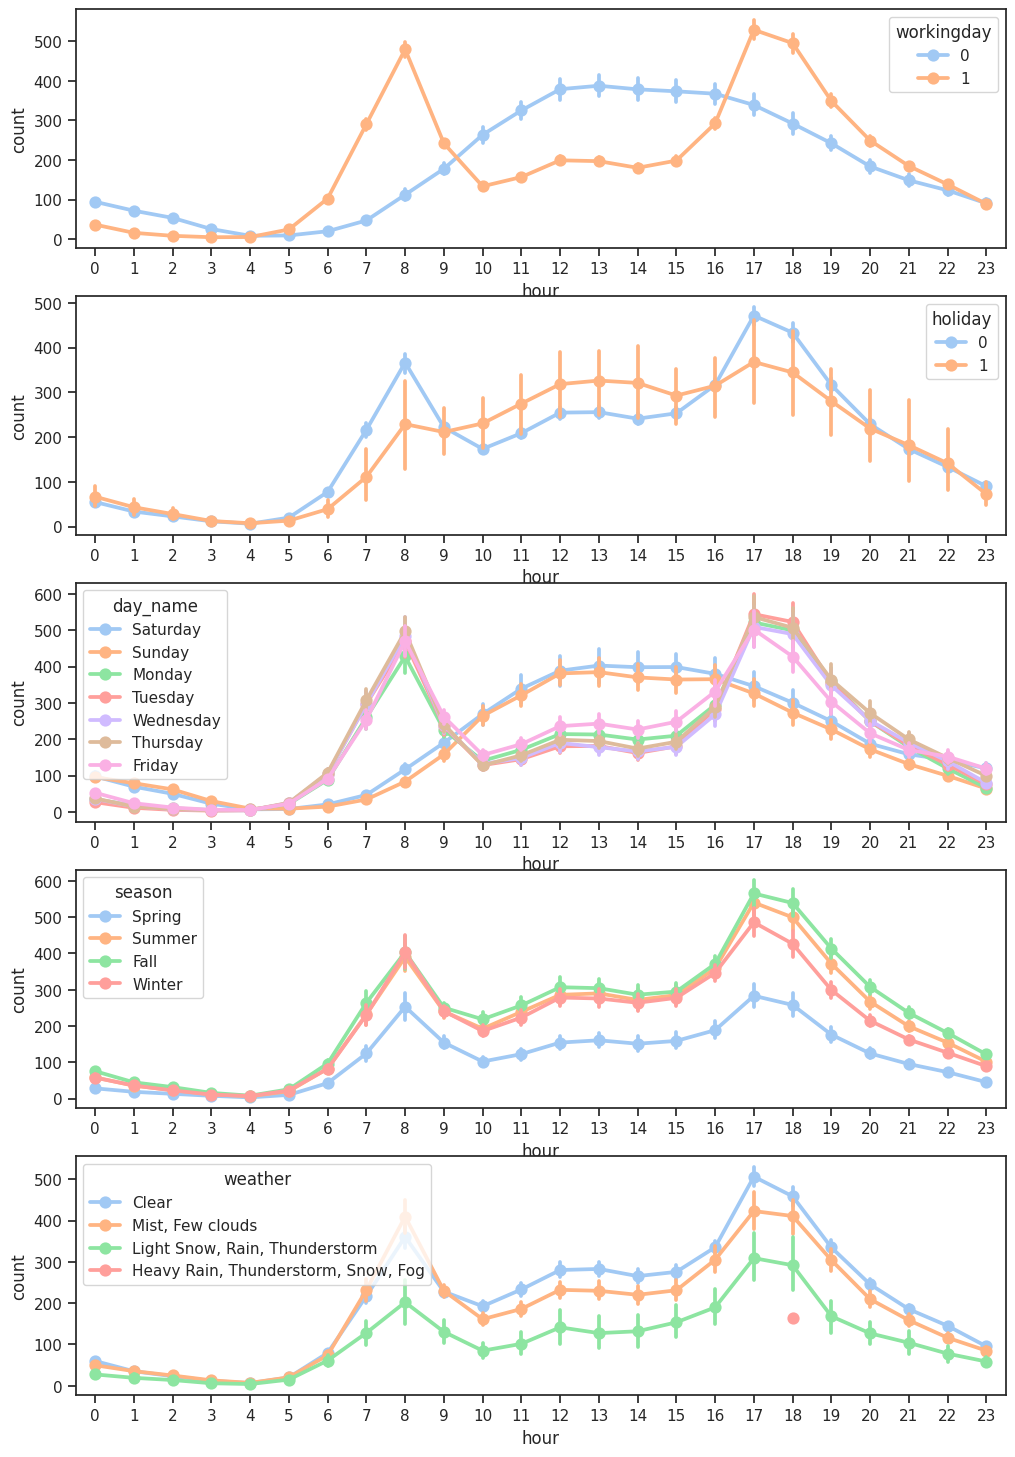

In [ ]:
# 1) m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12, 18)

# 2) 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트풀롯
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='day_name', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4])

- 근무일에는 출퇴근 시간에 대여 수량이 많고, 쉬는 날에는 오후 12시~2시에 가장 많다.
- 공휴일 여부도 비슷한 양상
- 요일에 따른 포인트 플롯도 비슷한 양상
- 계절에 따른 시간대별 포인트플롯 : 대여 수량은 가을에 가장 많고, 봄에 가장 적다.
- 날씨에 따른 시간대별 포인트풀롯 : 날씨가 좋을 때 대여량이 가장 많고, 폭우, 폭설이 내릴 때는 18시에 대여 건수가 있다.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

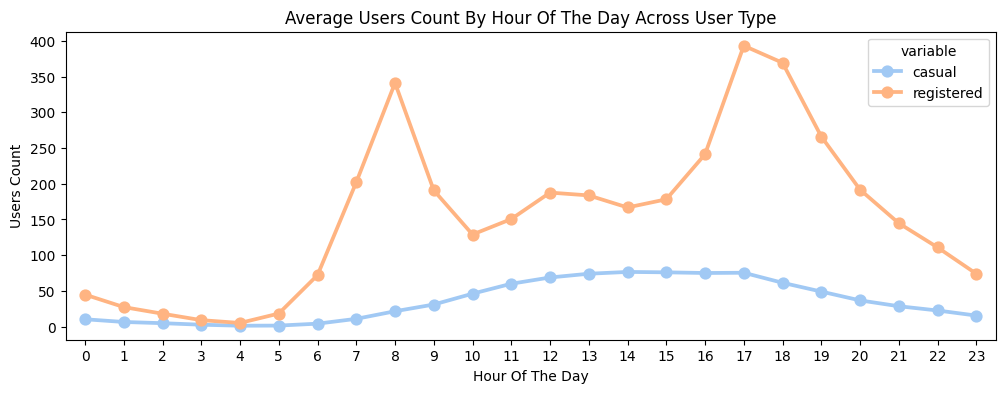

In [ ]:
fig, ax1= plt.subplots()
fig.set_size_inches(12,4)

hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

- 회원과 비회원의 대여량의 양상이 시간대별로 다른 것을 볼 수 있다.


### 회귀선을 포함한 산점도 그래프
- 수치형 데이터 간 상관관계를 파악하는 데 사용한다.
- 수치형 데이터인 온도, 체감 온도, 풍속, 습도별 대여 수량을 '회귀선을 포함한 산점도 그래프'로 그려보고자 함.

<Axes: xlabel='humidity', ylabel='count'>

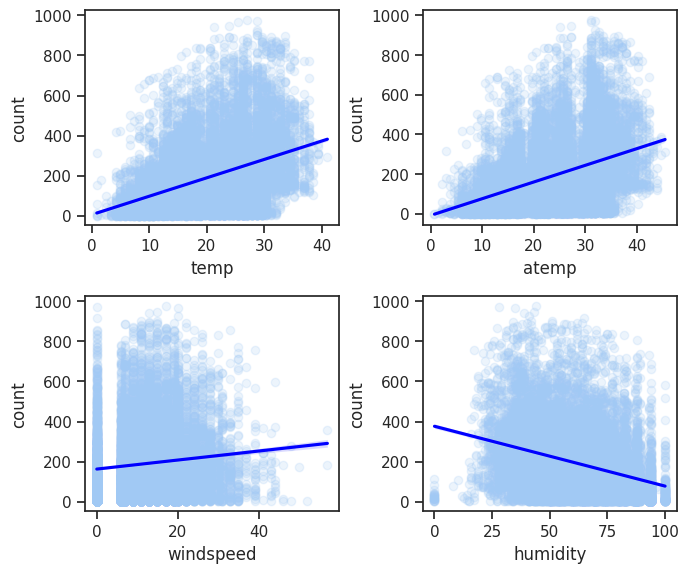

In [ ]:
# 1) m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(7, 6)

# 2) 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0],
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'}) # 산점도 그래프에 찍히는 점의 투명도 조절
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1],
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'}) # 평소보다 20% 수준으로 투명해짐
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0],
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'}) # blue는 회귀선의 색상 선택
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1],
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})


- 온도와 체감 온도가 높을수록 대여 수량이 많다.
- 습도는 낮을수록 대여를 많이 한다.
    - 대여 수량은 추울 때보다 따뜻할 때 많고, 습할 때보다 습하지 않을 때 많다.
- 풍속이 셀수록 대여 수량이 많다.
    - 바람이 약할수록 많을 것 같은데 조금 이상하다.
    - 이유는 windspeed 피처에 결측값이 많기 때문이다.
    - 자세히 보면 풍속이 0인 데이터가 꽤 많다.
    - 실제 풍속이 0이 아니라, 관측치가 없거나 오류로 인해 0으로 기록됐을 가능성이 높다.

## 3.2 수치형 데이터와의 상관관계
- 수치형 데이터끼리 어떤 상관관계가 있는지 알아보자.
- temp, atemp, humidity, windspeed, count는 수치형 데이터

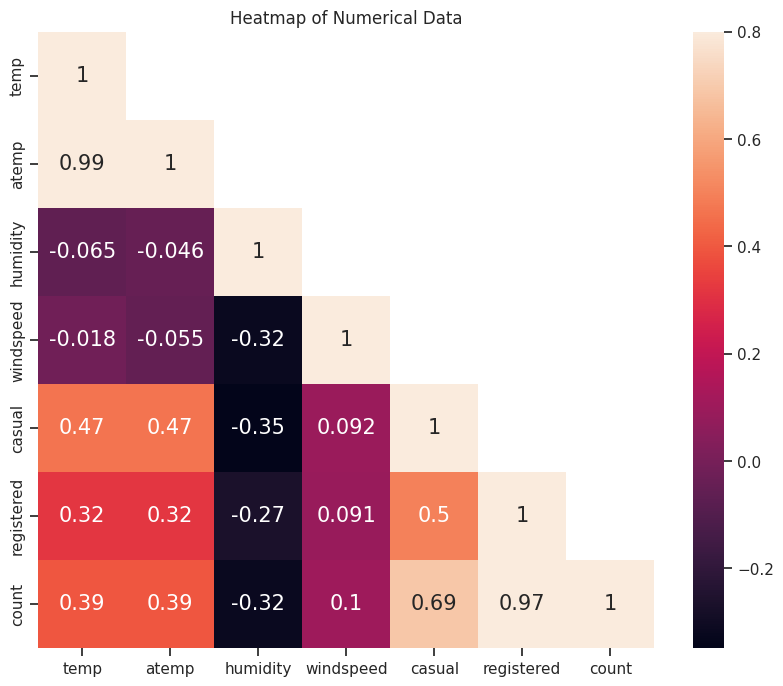

In [ ]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'casual','registered','count']].corr()
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(10,8)
sns.heatmap(corrMat, mask=mask,vmax=.8, square=True,annot=True)

ax.set(title='Heatmap of Numerical Data');

#### `타겟값과의 상관관계 파악`
- 온도 및 습도 특성은 대여량과 양의 상관관계와 음의 상관관계를 갖는다.
- 풍속(windspeed)는 대여량과의 상관 관계 값에서 상관관계가 낮은 것으로 보인다.
- 체감온도(atemp)와 실제온도(temp)는 서로 강한 상관 관계를 갖는다.
  - 모델링시 다중 공선성을 피하기 위해 둘 중 하나의 변수를 선택하는 것이 바람직하다.
- 비회원의 대여량과 회원의 대여량을 합한 값이 전체 대여량이므로 두 변수를 모두 삭제하거나 두 값을 예측하고 합하는 방식으로 전체 대여량을 예측하는 두가지 방식을 고려할 수 있다.

# 4. 모델링

## 분석 정리 및 모델링 전략


1. 파생 변수 생성
> datetime에서 year, month, hour, 요일(dayofweek) 변수를 추가

2. 전처리
> 이상치 처리
> - weather가 4인 데이터를 3으로 합쳐준다
> - atmp 변수에서 이상치 랜덤포레스트를 통해 보간
> - windspeed가 0인 데이터 랜덤포레스트를 통해 보간
> - 인코딩
    - 범주형 변수 원핫인코딩 수행
    - 원핫인코딩을 해보니 결과가 오히려 안좋아졌다.
    - 범주형 변수들도 약간의 순서적인 특성을 가지고 있는 것으로 보인다

3. 변수 선택
> 체감온도와 실제온도는 다중공선성이 강하므로 pca를 통해 하나로 합쳐줌

4. 타겟값 변환: 분포도 확인 결과, 타깃값인 count가 0 근처로 치우쳐져 있으므로 로그변환하여 정규분포에 가깝게 만들어야 한다.
> -  타겟값을 count가 아닌 log1p(count)로 변환해 사용할 것이므로 마지막에 다시 지수변환해 count로 복원해야 함
> - casual과 registered의 합이 count이므로 두 번의 예측 후 합을 통해 총 대여량 도출

## 랜덤포레스트
- RMSLE : 0.43089

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

In [ ]:
# Load the dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
# Combine train and test data for preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)

# 1. Creating derived variables
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek

# 2. Pre-treatment
# Outlier processing
data['weather'] = data['weather'].replace({4: 3})  # Combine weather data of 4 into 3

# Interpolation through outlier random forest in atmp variable
atmp_data = data.dropna(subset=['atemp'])
X_atmp = atmp_data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis=1)
y_atmp = atmp_data['atemp']
rf_atmp = RandomForestRegressor()
rf_atmp.fit(X_atmp, y_atmp)
data['atemp'] = np.where(data['atemp'].isna(), rf_atmp.predict(data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis=1)), data['atemp'])

# Interpolation through random forest of data with windspeed of 0
windspeed_data = data[data['windspeed'] != 0]
X_windspeed = windspeed_data.drop(['datetime', 'count', 'casual', 'registered', 'windspeed'], axis=1)
y_windspeed = windspeed_data['windspeed']
rf_windspeed = RandomForestRegressor()
rf_windspeed.fit(X_windspeed, y_windspeed)
data['windspeed'] = np.where(data['windspeed'] == 0, rf_windspeed.predict(data.drop(['datetime', 'count', 'casual', 'registered', 'windspeed'], axis=1)), data['windspeed'])

# 3. One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['season', 'dayofweek'])

# 4. Variable selection
# Combine perceived temperature and actual temperature into one through PCA
scaler = StandardScaler()
scaled_temp = scaler.fit_transform(data[['temp', 'atemp']])
pca = PCA(n_components=1)
data['temperature'] = pca.fit_transform(scaled_temp)

# 4. Target value conversion
data[['count', 'casual', 'registered']] = np.log1p(data[['count', 'casual', 'registered']])

# Split back into train and test data
train_data = data[data['count'].notnull()]
test_data = data[data['count'].isnull()]

# Model Training and Prediction
X_train = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)
y_casual = train_data['casual']
y_registered = train_data['registered']
y_count = train_data['count']

# Train a RandomForestRegressor for casual
rf_casual = RandomForestRegressor()
rf_casual.fit(X_train, y_casual)
casual_predictions = rf_casual.predict(X_train)

# Train a RandomForestRegressor for registered
rf_registered = RandomForestRegressor()
rf_registered.fit(X_train, y_registered)
registered_predictions = rf_registered.predict(X_train)

# Train a RandomForestRegressor for count
rf_count = RandomForestRegressor()
rf_count.fit(X_train, y_count)
count_predictions = rf_count.predict(X_train)

# Evaluate
rmsle_casual = np.sqrt(mean_squared_log_error(np.expm1(y_casual), np.expm1(casual_predictions)))
rmsle_registered = np.sqrt(mean_squared_log_error(np.expm1(y_registered), np.expm1(registered_predictions)))
rmsle_count = np.sqrt(mean_squared_log_error(np.expm1(y_count), np.expm1(count_predictions)))

print("Root Mean Squared Log Error for Casual:", rmsle_casual)
print("Root Mean Squared Log Error for Registered:", rmsle_registered)
print("Root Mean Squared Log Error for Count:", rmsle_count)

Root Mean Squared Log Error for Casual: 0.1936539730848964
Root Mean Squared Log Error for Registered: 0.11577210833040409
Root Mean Squared Log Error for Count: 0.11971849879233382


In [ ]:
# Prediction for test data
X_test = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

# Predictions for test data
test_casual_predictions = rf_casual.predict(X_test)
test_registered_predictions = rf_registered.predict(X_test)
test_count_predictions = rf_count.predict(X_test)

# Convert predictions back to original scale
test_casual_predictions = np.expm1(test_casual_predictions)
test_registered_predictions = np.expm1(test_registered_predictions)
test_count_predictions = np.expm1(test_count_predictions)

# Reconstruct total count
test_data['count'] = test_casual_predictions + test_registered_predictions
test_data['count'] = (test_data['count'] + test_count_predictions) /2
test_data[['datetime', 'count']].to_csv('predicted_test_data_rf.csv', index=False)

<ipython-input-17-09701eacbb17>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['count'] = test_casual_predictions + test_registered_predictions
<ipython-input-17-09701eacbb17>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['count'] = (test_data['count'] + test_count_predictions) /2


## xgboost를 통한 예측
- RMSLE : 0.43616

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

# Train a XGBoost model for casual
xgb_casual = xgb.XGBRegressor()
xgb_casual.fit(X_train, y_casual)
casual_predictions = xgb_casual.predict(X_train)

# Train a XGBoost model for registered
xgb_registered = xgb.XGBRegressor()
xgb_registered.fit(X_train, y_registered)
registered_predictions = xgb_registered.predict(X_train)

# Train a XGBoost model for count
xgb_count = xgb.XGBRegressor()
xgb_count.fit(X_train, y_count)
count_predictions = xgb_count.predict(X_train)

# Clip predictions to ensure non-negativity
casual_predictions = np.clip(casual_predictions, 0, None)
registered_predictions = np.clip(registered_predictions, 0, None)
count_predictions = np.clip(count_predictions, 0, None)

# Evaluate
rmsle_casual = np.sqrt(mean_squared_log_error(np.expm1(y_casual), np.expm1(casual_predictions)))
rmsle_registered = np.sqrt(mean_squared_log_error(np.expm1(y_registered), np.expm1(registered_predictions)))
rmsle_count = np.sqrt(mean_squared_log_error(np.expm1(y_count), np.expm1(count_predictions)))

print("Root Mean Squared Log Error for Casual:", rmsle_casual)
print("Root Mean Squared Log Error for Registered:", rmsle_registered)
print("Root Mean Squared Log Error for Count:", rmsle_count)

# Prediction for test data
X_test = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

# Predictions for test data
test_casual_predictions = xgb_casual.predict(X_test)
test_registered_predictions = xgb_registered.predict(X_test)
test_count_predictions = xgb_count.predict(X_test)

# Convert predictions back to original scale
test_casual_predictions = np.expm1(test_casual_predictions)
test_registered_predictions = np.expm1(test_registered_predictions)
test_count_predictions = np.expm1(test_count_predictions)

# Clip predictions to ensure non-negativity
test_casual_predictions = np.clip(test_casual_predictions, 0, None)
test_registered_predictions = np.clip(test_registered_predictions, 0, None)
test_count_predictions = np.clip(test_count_predictions, 0, None)

# Reconstruct total count
test_data['count'] = test_casual_predictions + test_registered_predictions
test_data['count'] = (test_data['count'] + test_count_predictions) /2

# Save the predictions to a CSV file
test_data[['datetime', 'count']].to_csv('predicted_test_data_xgboost.csv', index=False)


Root Mean Squared Log Error for Casual: 0.32533826832135176
Root Mean Squared Log Error for Registered: 0.18570654678970214
Root Mean Squared Log Error for Count: 0.1881561146816879


<ipython-input-23-f15d99b7f1d2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['count'] = test_casual_predictions + test_registered_predictions
<ipython-input-23-f15d99b7f1d2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['count'] = (test_data['count'] + test_count_predictions) /2


## Automl 활용

In [ ]:
!pip install pycaret

원핫 인코딩 결과 오히려 결과가 안좋아져서 원핫 인코딩 빼고 다시 진행

### count_train

In [ ]:
# Load the dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Combine train and test data for preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)

# 1. Creating derived variables
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek

# 2. Pre-treatment
# Outlier processing
data['weather'] = data['weather'].replace({4: 3})  # Combine weather data of 4 into 3

# Interpolation through outlier random forest in atmp variable
atmp_data = data.dropna(subset=['atemp'])
X_atmp = atmp_data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis=1)
y_atmp = atmp_data['atemp']
rf_atmp = RandomForestRegressor()
rf_atmp.fit(X_atmp, y_atmp)
data['atemp'] = np.where(data['atemp'].isna(), rf_atmp.predict(data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis=1)), data['atemp'])

# Interpolation through random forest of data with windspeed of 0
windspeed_data = data[data['windspeed'] != 0]
X_windspeed = windspeed_data.drop(['datetime', 'count', 'casual', 'registered', 'windspeed'], axis=1)
y_windspeed = windspeed_data['windspeed']
rf_windspeed = RandomForestRegressor()
rf_windspeed.fit(X_windspeed, y_windspeed)
data['windspeed'] = np.where(data['windspeed'] == 0, rf_windspeed.predict(data.drop(['datetime', 'count', 'casual', 'registered', 'windspeed'], axis=1)), data['windspeed'])

# Variable selection
# Combine perceived temperature and actual temperature into one through PCA
scaler = StandardScaler()
scaled_temp = scaler.fit_transform(data[['temp', 'atemp']])
pca = PCA(n_components=1)
data['temperature'] = pca.fit_transform(scaled_temp)

# Target value conversion
data[['count', 'casual', 'registered']] = np.log1p(data[['count', 'casual', 'registered']])

# Split back into train and test data
train_data = data[data['count'].notnull()]
test_data = data[data['count'].isnull()]

# Model Training and Prediction
X_train = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)
y_casual = train_data['casual']
y_registered = train_data['registered']
y_count = train_data['count']

# Prediction for test data
X_test = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [ ]:
# Initialize the setup
count_train = pd.concat([X_train, y_count], axis=1)
casual_train = pd.concat([X_train, y_casual], axis=1)
registered_train = pd.concat([X_train, y_registered], axis=1)

In [ ]:
import pycaret
from pycaret.regression import *

# 모델링
reg = setup(data = count_train, target = 'count', train_size = 0.8,\
               normalize = True, transformation = True,\
               pca = True, pca_method = 'linear', pca_components = 2)
best_model = compare_models(sort='RMSLE')

# 모델 저장
save_model(best_model, 'best_model')

# test 데이터 예측
predictions = predict_model(best_model, data=X_test)

# Submission.csv 형태 만들어서 저장
submission = pd.DataFrame({'datetime': test_data['datetime'], 'count': np.expm1(predictions['prediction_label'])})
submission.to_csv('Submission.csv', index=False)


,Description,Value
0,Session id,1985
1,Target,count
2,Target type,Regression
3,Original data shape,"(10886, 14)"
4,Transformed data shape,"(10886, 3)"
5,Transformed train set shape,"(8708, 3)"
6,Transformed test set shape,"(2178, 3)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.9135,1.3999,1.1827,0.3004,0.2690,0.3167,1.7020
lightgbm,Light Gradient Boosting Machine,0.9163,1.4177,1.1902,0.2914,0.2697,0.3150,1.6960
ada,AdaBoost Regressor,0.9958,1.5103,1.2286,0.2450,0.2725,0.3231,0.5080
lr,Linear Regression,0.9386,1.4556,1.2060,0.2730,0.2740,0.3270,0.3640
ridge,Ridge Regression,0.9386,1.4556,1.2060,0.2730,0.2740,0.3270,0.1860
lar,Least Angle Regression,0.9386,1.4556,1.2060,0.2730,0.2740,0.3270,0.4440
br,Bayesian Ridge,0.9386,1.4556,1.2060,0.2730,0.2740,0.3271,0.4610
xgboost,Extreme Gradient Boosting,0.9462,1.5376,1.2395,0.2312,0.2788,0.3201,0.8340
huber,Huber Regressor,0.9212,1.4853,1.2181,0.2585,0.2804,0.3384,0.2150
rf,Random Forest Regressor,0.9654,1.5969,1.2631,0.2011,0.2820,0.3244,3.6890


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


### casual_train

In [ ]:
# 모델링
reg = setup(data = casual_train, target = 'casual', train_size = 0.8,\
               normalize = True, transformation = True,\
               pca = True, pca_method = 'linear', pca_components = 2)
best_model_casual = compare_models(sort='RMSLE')

# 모델 저장
save_model(best_model_casual, 'best_model_casual')

# test 데이터 예측
casual_predictions = predict_model(best_model_casual, data=X_test)
casual_predictions = np.expm1(casual_predictions['prediction_label'])

,Description,Value
0,Session id,6320
1,Target,casual
2,Target type,Regression
3,Original data shape,"(10886, 14)"
4,Transformed data shape,"(10886, 3)"
5,Transformed train set shape,"(8708, 3)"
6,Transformed test set shape,"(2178, 3)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.5108,0.7089,0.6521,0.2838,0.2427,0.2232,0.8520
lightgbm,Light Gradient Boosting Machine,0.5131,0.7148,0.6548,0.2812,0.2428,0.2248,0.3410
ridge,Ridge Regression,0.5280,0.7473,0.6695,0.2667,0.2474,0.2291,0.2070
lar,Least Angle Regression,0.5280,0.7473,0.6695,0.2667,0.2474,0.2291,0.1520
br,Bayesian Ridge,0.5280,0.7473,0.6695,0.2667,0.2474,0.2291,0.3980
lr,Linear Regression,0.5280,0.7473,0.6695,0.2667,0.2474,0.2291,0.1540
xgboost,Extreme Gradient Boosting,0.5295,0.7705,0.6798,0.2565,0.2487,0.2340,0.2160
huber,Huber Regressor,0.5267,0.7502,0.6707,0.2654,0.2488,0.2323,0.1640
ada,AdaBoost Regressor,0.5387,0.7607,0.6755,0.2608,0.2504,0.2275,0.2140
rf,Random Forest Regressor,0.5377,0.8007,0.6930,0.2430,0.2510,0.2356,1.5730


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


### registered_train

In [ ]:
# 모델링
reg = setup(data = registered_train, target = 'registered', train_size = 0.8,\
               normalize = True, transformation = True,\
               pca = True, pca_method = 'linear', pca_components = 2)
best_model_registered = compare_models(sort='RMSLE')

# 모델 저장
save_model(best_model_registered, 'best_model_registered')

# test 데이터 예측
registered_predictions = predict_model(best_model_registered, data=X_test)
registered_predictions = np.expm1(registered_predictions['prediction_label'])

# Submission.csv 형태 만들어서 저장
submission = pd.DataFrame({'datetime': test_data['datetime'], 'count': casual_predictions + registered_predictions})
submission.to_csv('Submission.csv', index=False)

,Description,Value
0,Session id,5996
1,Target,registered
2,Target type,Regression
3,Original data shape,"(10886, 14)"
4,Transformed data shape,"(10886, 3)"
5,Transformed train set shape,"(8708, 3)"
6,Transformed test set shape,"(2178, 3)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.7339,1.1306,0.9507,0.2153,0.2248,0.2655,0.7000
lightgbm,Light Gradient Boosting Machine,0.7396,1.1558,0.9613,0.2023,0.2263,0.2656,1.2240
ada,AdaBoost Regressor,0.7973,1.2151,0.9858,0.1714,0.2278,0.2711,0.3680
lr,Linear Regression,0.7561,1.1803,0.9715,0.1896,0.2296,0.2756,0.2670
ridge,Ridge Regression,0.7561,1.1803,0.9715,0.1896,0.2296,0.2756,0.1720
lar,Least Angle Regression,0.7561,1.1803,0.9715,0.1896,0.2296,0.2756,0.1670
br,Bayesian Ridge,0.7561,1.1803,0.9715,0.1896,0.2296,0.2756,0.1660
xgboost,Extreme Gradient Boosting,0.7653,1.2604,1.0039,0.1480,0.2345,0.2707,0.3050
huber,Huber Regressor,0.7428,1.1991,0.9791,0.1800,0.2347,0.2855,0.2950
knn,K Neighbors Regressor,0.7767,1.2933,1.0168,0.1313,0.2354,0.2710,0.1780


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


In [ ]:
import pycaret
from pycaret.regression import *

# 모델링
reg = setup(data = count_train, target = 'count', train_size = 0.8, normalize = True,\
               pca = True, pca_method = 'linear', pca_components = 2)
best_model = compare_models(sort='RMSLE')

# 모델 저장
save_model(best_model, 'best_model')

# test 데이터 예측
predictions = predict_model(best_model, data=X_test)

# Submission.csv 형태 만들어서 저장
submission = pd.DataFrame({'datetime': test_data['datetime'], 'count': np.expm1(predictions['prediction_label'])})
submission.to_csv('Submission2.csv', index=False)


,Description,Value
0,Session id,7783
1,Target,count
2,Target type,Regression
3,Original data shape,"(10886, 14)"
4,Transformed data shape,"(10886, 3)"
5,Transformed train set shape,"(8708, 3)"
6,Transformed test set shape,"(2178, 3)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9234,1.4367,1.1983,0.2749,0.2702,0.3154,0.7630
gbr,Gradient Boosting Regressor,0.9273,1.4308,1.1959,0.2778,0.2704,0.3185,0.7260
ada,AdaBoost Regressor,1.0140,1.5465,1.2432,0.2196,0.2736,0.3242,0.2010
lr,Linear Regression,0.9556,1.5045,1.2263,0.2407,0.2771,0.3312,0.1370
ridge,Ridge Regression,0.9556,1.5045,1.2263,0.2407,0.2771,0.3312,0.0640
lar,Least Angle Regression,0.9556,1.5045,1.2263,0.2407,0.2771,0.3312,0.0710
br,Bayesian Ridge,0.9556,1.5045,1.2263,0.2407,0.2771,0.3312,0.0630
xgboost,Extreme Gradient Boosting,0.9504,1.5453,1.2428,0.2197,0.2776,0.3186,0.2210
rf,Random Forest Regressor,0.9664,1.5928,1.2618,0.1955,0.2803,0.3213,2.6630
knn,K Neighbors Regressor,0.9711,1.6160,1.2709,0.1842,0.2822,0.3241,0.1270


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


## Blended model
- 정형데이터에서 좋은 성능을 내는 것으로 알려진 랜덤 포레스트, xgboost, lightgbm 모델을 모두 활용해서 결과를 확인하였다.
- 최종적으로 가장 좋은 성능을 낼 수 있었다.
- RMSLE : 0.40786

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Assuming train_data and test_data are your train and test datasets

# Define the features and target
X_train = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)
y_train = train_data['count']
X_test = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

# Train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(force_col_wise=True)
lgb_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

# Blend predictions using simple averaging
blended_predictions = (rf_predictions + xgb_predictions + lgb_predictions) / 3

# Prepare submission
submission = pd.DataFrame({'datetime': test_data['datetime'], 'count': np.expm1(blended_predictions)})
submission.to_csv('Blended_Predictions.csv', index=False)

[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 10886, number of used features: 13
[LightGBM] [Info] Start training from score 4.591364


# 5. 결론
- 시간 및 메모리가 부족하여 다양한 시도를 해보지 못했지만, 하이퍼 파라미터 튜닝 등 모델을 조금 더 개선시킬 여지가 있어보인다.
- Automl을 활용하여 자동적으로 좋은 모델을 고르는 방식을 활용하면 좀 더 빠르고 편하게 좋은 결론을 낼 수 있을 것으로 보인다.
- 단순히 명목형 변수라고 원핫인코딩을 한다고 성능이 좋아지는 것은 아님을 깨달았다.
  - 이는 1,2,3,4의 순서적인 의미를 담을수도 있기 때문인 것으로 보인다.
- 부트캠프에서 좀 더 공부해서 어떤식으로 모델을 개선하기위해 파라미터를 수정해가고 분석해 갈 수 있을지 공부하고 싶다.